# Train the vgg16 model for phishing detection

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("phi_dataset/")
model_dir = pathlib.Path('phi_models/')
checkpoint_dir = pathlib.Path('phi_checkpoints/')

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-07-25_17;29;24.257896


## Params

In [56]:
model_name = "vgg16"
batch_size = 16
img_height = 224
img_width = 224

rest_split_ratio = 0.2
test_split_ratio = 0.2


## Load dataset

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 8433 files for training.


In [24]:
rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 2108 files for validation.


In [25]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

132


In [26]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [27]:
class_names = train_ds.class_names

In [28]:
class_names

['phishing', 'trusted_list']

## Visualize data

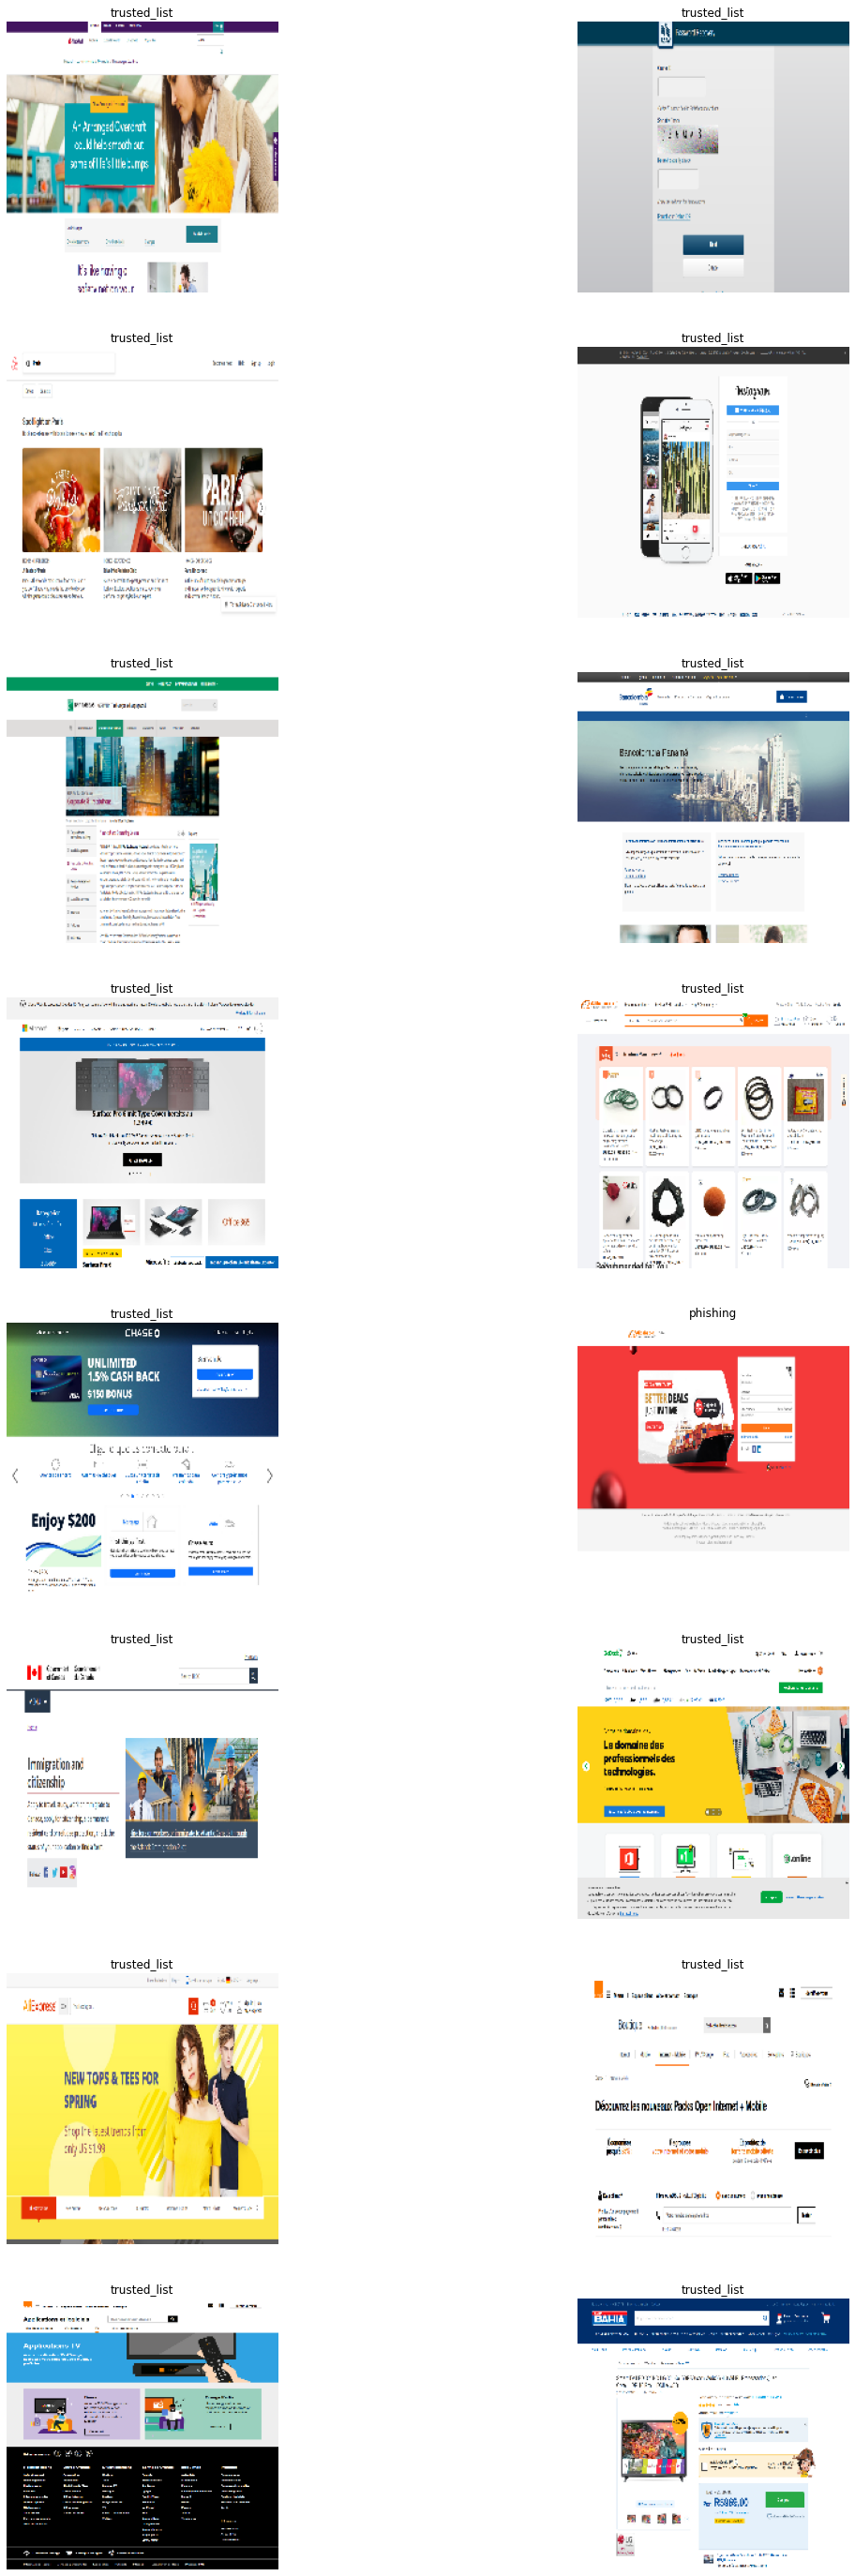

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [47]:
input_tensor = layers.Input((img_width, img_height, 3))
x = keras.applications.vgg16.preprocess_input(input_tensor)
vgg_model = keras.applications.vgg16.VGG16(weights=None)
vgg_output = vgg_model(x)
output_tensor = layers.Dense(1)(vgg_output)
model = keras.Model(input_tensor, output_tensor)

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [49]:
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_4 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1001      
Total params: 138,358,545
Trainable params: 138,358,545
Non-trainable params: 0
_________________________________________________________________


In [50]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Training

In [51]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [55]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/20
528/528 [==============================] - 95s 153ms/step - loss: 0.3531 - accuracy: 0.8869 - val_loss: 0.3563 - val_accuracy: 0.8853

Epoch 00001: val_loss did not improve from 0.35628
Epoch 2/20
528/528 [==============================] - 88s 143ms/step - loss: 0.3531 - accuracy: 0.8869 - val_loss: 0.3563 - val_accuracy: 0.8853

Epoch 00002: val_loss did not improve from 0.35628
Epoch 3/20
528/528 [==============================] - 86s 140ms/step - loss: 0.3531 - accuracy: 0.8869 - val_loss: 0.3563 - val_accuracy: 0.8853

Epoch 00003: val_loss did not improve from 0.35628
Epoch 4/20
528/528 [==============================] - 86s 140ms/step - loss: 0.3531 - accuracy: 0.8869 - val_loss: 0.3563 - val_accuracy: 0.8853

Epoch 00004: val_loss did not improve from 0.35628
Epoch 5/20
528/528 [==============================] - 86s 141ms/step - loss: 0.3531 - accuracy: 0.8869 - val_loss: 0.3563 - val_accuracy: 0.8853

Epoch 00005: val_loss did not improve from 0.35628
Epoch 00005: ea

## Save model

In [53]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}_w{img_width}_h{img_height}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: phi_models\2021-07-25_17;29;24.257896_custom2_valacc0.8853_e8_b16_w224_h224.tf\assets


## Load model

In [54]:
# change filename to the model you want to load
model_filename = "2021-07-23_10:41:26.182203_custom1_valacc0.9185_e4_b16.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

OSError: SavedModel file does not exist at: phi_models\2021-07-23_10:41:26.182203_custom1_valacc0.9185_e4_b16.tf\{saved_model.pbtxt|saved_model.pb}

## Visulaize loss and acc

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [ ]:
val_results = model.evaluate(test_ds)
print("val loss, val acc:", val_results)

In [ ]:
results = model.evaluate(test_ds)
print("test loss, test acc:", results)
